In [1]:
import pandas as pd
import numpy as np
import itertools
from matplotlib import pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.graphics.factorplots import interaction_plot
from sklearn.linear_model import LinearRegression

# 通気層の対流熱伝達率の推定方法の検証
## 分析用データの読み込み

In [2]:
# CSVファイルを読み込む
df = pd.read_csv('wall_status_data_frame_detailed.csv', index_col=0)

# 温度差の列を追加
df["delta_theta_as_e-theta_r"] = df["theta_as_e"] - df["theta_r"]
df["delta_theta_sat-theta_r"] = df["theta_sat"] - df["theta_r"]


# 収束しなかった場合のデータを削除する
df = df.query("is_optimize_succeed == True")

# 分析用にメッセージ列を削除
df = df.drop(["is_optimize_succeed", "optimize_message"], axis=1)

# 1つでも欠損値NaNがある行を削除する
df = df[~np.isnan(df).any(axis=1)]

## 冬期条件、夏期条件の計算結果をそれぞれ抽出

In [3]:
# 冬期条件の計算結果を抽出
df_winter = df.query("theta_e <= 10.0 & theta_r == 20.0")
df_winter

,theta_e,theta_r,j_surf,a_surf,C_1,C_2,l_h,l_w,l_d,angle,...,theta_as_e,k_e,q_room_side,heat_balance_0,heat_balance_1,heat_balance_2,heat_balance_3,heat_balance_4,delta_theta_as_e-theta_r,delta_theta_sat-theta_r
0,-10.0,20.0,0.0,0.0,0.5,0.1,3.0,0.05,0.05,0.0,...,-4.623813,0.820794,-2.363617,0.000000e+00,2.220446e-15,-1.776357e-15,2.842171e-14,-2.220446e-16,-24.623813,-30.0
1,-10.0,20.0,0.0,0.0,0.5,0.1,3.0,0.05,0.05,0.0,...,-4.887580,0.829586,-2.409223,0.000000e+00,3.552714e-15,3.552714e-15,0.000000e+00,-4.440892e-16,-24.887580,-30.0
2,-10.0,20.0,0.0,0.0,0.5,0.1,3.0,0.05,0.05,0.0,...,-4.949801,0.831660,-2.426662,-2.842171e-14,3.552714e-15,-7.105427e-15,-2.842171e-14,-4.440892e-16,-24.949801,-30.0
3,-10.0,20.0,0.0,0.0,0.5,0.1,3.0,0.05,0.05,0.0,...,-9.856252,0.995208,-2.892881,2.842171e-14,8.881784e-15,0.000000e+00,0.000000e+00,0.000000e+00,-29.856252,-30.0
4,-10.0,20.0,0.0,0.0,0.5,0.1,3.0,0.05,0.05,0.0,...,-9.814749,0.993825,-2.901498,-2.842171e-14,-3.552714e-15,-7.105427e-15,0.000000e+00,-8.881784e-16,-29.814749,-30.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295240,10.0,20.0,1000.0,1.0,100.0,5.0,12.0,10.00,0.30,90.0,...,24.918480,0.163949,11.551022,-4.547474e-13,-3.979039e-13,-1.136868e-13,0.000000e+00,-1.776357e-15,4.918480,30.0
295241,10.0,20.0,1000.0,1.0,100.0,5.0,12.0,10.00,0.30,90.0,...,28.197296,0.273243,20.277198,4.547474e-13,0.000000e+00,1.136868e-13,-5.684342e-14,8.881784e-16,8.197296,30.0
295242,10.0,20.0,1000.0,1.0,100.0,5.0,12.0,10.00,0.30,90.0,...,15.758518,-0.141383,-9.942546,-4.547474e-13,1.527667e-12,8.526513e-14,2.842171e-14,-1.776357e-15,-4.241482,30.0
295243,10.0,20.0,1000.0,1.0,100.0,5.0,12.0,10.00,0.30,90.0,...,20.797442,0.026581,1.971000,4.547474e-13,-3.410605e-13,-5.684342e-14,0.000000e+00,8.881784e-16,0.797442,30.0


In [4]:
# 夏期条件の計算結果を抽出
df_summer = df.query("theta_e >= 25.0 & theta_r == 27.0")
df_summer

,theta_e,theta_r,j_surf,a_surf,C_1,C_2,l_h,l_w,l_d,angle,...,theta_as_e,k_e,q_room_side,heat_balance_0,heat_balance_1,heat_balance_2,heat_balance_3,heat_balance_4,delta_theta_as_e-theta_r,delta_theta_sat-theta_r
413343,25.0,27.0,0.0,0.0,0.5,0.1,3.0,0.05,0.05,0.0,...,25.356350,0.821825,-0.153308,0.000000e+00,-1.776357e-15,7.105427e-15,0.000000e+00,1.776357e-15,-1.643650,-2.0
413344,25.0,27.0,0.0,0.0,0.5,0.1,3.0,0.05,0.05,0.0,...,25.334142,0.832929,-0.160680,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.665858,-2.0
413345,25.0,27.0,0.0,0.0,0.5,0.1,3.0,0.05,0.05,0.0,...,25.333373,0.833313,-0.162148,0.000000e+00,-1.421085e-14,-2.842171e-14,0.000000e+00,0.000000e+00,-1.666627,-2.0
413346,25.0,27.0,0.0,0.0,0.5,0.1,3.0,0.05,0.05,0.0,...,25.011235,0.994383,-0.191482,0.000000e+00,1.421085e-14,0.000000e+00,-2.842171e-14,0.000000e+00,-1.988765,-2.0
413347,25.0,27.0,0.0,0.0,0.5,0.1,3.0,0.05,0.05,0.0,...,25.018480,0.990760,-0.192738,0.000000e+00,1.421085e-14,0.000000e+00,-2.842171e-14,3.552714e-15,-1.981520,-2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
708583,35.0,27.0,1000.0,1.0,100.0,5.0,12.0,10.00,0.30,90.0,...,50.470072,0.488960,56.325852,0.000000e+00,-4.547474e-13,-1.136868e-13,8.526513e-14,0.000000e+00,23.470072,48.0
708584,35.0,27.0,1000.0,1.0,100.0,5.0,12.0,10.00,0.30,90.0,...,53.646967,0.555145,67.563938,-1.818989e-12,-2.842171e-13,-2.273737e-13,2.842171e-14,0.000000e+00,26.646967,48.0
708585,35.0,27.0,1000.0,1.0,100.0,5.0,12.0,10.00,0.30,90.0,...,40.829960,0.288124,32.615303,-9.094947e-13,4.227729e-13,5.684342e-14,-2.842171e-14,-3.552714e-15,13.829960,48.0
708586,35.0,27.0,1000.0,1.0,100.0,5.0,12.0,10.00,0.30,90.0,...,46.506060,0.406376,48.920559,-9.094947e-13,1.023182e-12,2.273737e-13,-8.526513e-14,7.105427e-15,19.506060,48.0


### 通気層の対流熱伝達率（h_cv）、放射熱伝達率（h_rv）の要約統計量を表示

In [5]:
# 冬期条件
df_winter.loc[:,["h_cv","h_rv"]].describe()

,h_cv,h_rv
count,157464.000000,157464.000000
mean,4.340636,2.342455
std,1.902085,1.524281
min,0.032703,0.409954
25%,2.827014,0.525650
50%,4.449137,2.353212
75%,5.845541,3.788173
max,9.267936,6.241686


In [6]:
# 夏期条件
df_summer.loc[:,["h_cv","h_rv"]].describe()

,h_cv,h_rv
count,177147.000000,177147.000000
mean,3.900725,3.065066
std,1.935850,1.974381
min,0.004872,0.594610
25%,2.371344,0.664545
50%,3.836230,3.072361
75%,5.326074,5.109931
max,9.264223,7.796900


## 作図用の関数を定義
### 散布図（線形回帰式あり）を作図する関数を定義

In [7]:
def setPltSingle(df:pd.DataFrame, fig_title:str, x_label:str, y_label:str, x_data_name:str, y_data_name:str,
                is_fit_intercept:bool):
    
    """
    グラフを描画する（2変数の散布図、線形回帰式あり）
    
    :param df: CSVファイルの全データ
    :param fig_title: グラフタイトル
    :param x_label: X軸のラベル
    :param y_label: Y軸のラベル
    :param x_data_name: X軸に設定するデータの名称
    :param y_data_name: Y軸に設定するデータの名称
    :return: なし
    """
        
    # グラフを表示する領域（figureオブジェクト）、グラフを描画する領域（Axesオブジェクト）を作成
    # グラフサイズを指定する　デフォルト：figsize=(6.4, 4.8)、小サイズ：figsize=(4.0, 3.5)
    fig, ax = plt.subplots(figsize=(3.7, 3.5))
    
    # フォントサイズを設定
    plt.rcParams["font.size"] = 14

    # グラフタイトルを設定
    fig.suptitle(fig_title)
    
    # 単回帰分析を行うsklearn.linear_model.LinearRegressionクラスを読み込み
    # fit_intercept:切片を求める計算をするか（True:切片を計算する、False:切片を計算しない）
    model_lr = LinearRegression(fit_intercept=is_fit_intercept)

    # 補助軸の設定
    ax.grid(which='major', color='gray', linestyle='-')
    ax.grid(which='minor', color='gray', linestyle='-')
    
    # 軸ラベルの設定
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    
    # 描画データ設定
    x = df[x_data_name].to_numpy().reshape(-1, 1)
    y = df[y_data_name].to_numpy().reshape(-1, 1)

    # 線形回帰モデルを作成
    model_lr.fit(x, y)
    a = model_lr.coef_[0][0]   # 回帰係数
    if is_fit_intercept == True:  # 切片 (誤差)
        b = model_lr.intercept_[0]
    else:
        b = model_lr.intercept_
    r2 = model_lr.score(x, y)  # 決定係数
    
    # 散布図の描画設定
    ax.scatter(x, y, s=30, marker=".")
        
    # 線形近似の描画設定
    ax.plot(x, model_lr.predict(x),color="black")

    # 近似式の表示（text関数の引数：x座標、y座標、表示するテキスト）
    ax.text(np.mean(x) - np.mean(x) * 0.2, np.mean(y) + np.mean(y) * 0.1, 'y='+ str(round(a, 3)) +'x+'+str(round(b,3)))
        
    # 決定係数の表示
    ax.text(np.mean(x) - np.mean(x) * 0.2, np.mean(y) + np.mean(y) * 0.4, 'R2='+ str(round(r2,4)))

    # グラフ描画
    plt.show()

### 推定値の確認用グラフ

In [8]:
def setPltComparison(fig_title:str, x_label:str, y_label:str, x_data:pd.DataFrame, y_data:pd.DataFrame,
                     xlim_min:float, xlim_max:float, ylim_min:float, ylim_max:float):
    
    # グラフを表示する領域（figureオブジェクト）、グラフを描画する領域（Axesオブジェクト）を作成
    # グラフサイズを指定する　デフォルト：figsize=(6.4, 4.8)、小サイズ：figsize=(4.0, 3.5)
    fig, ax = plt.subplots(figsize=(3.7, 3.5))

    # フォントサイズを設定
    plt.rcParams["font.size"] = 14
    
    # グラフタイトルを設定
    fig.suptitle(fig_title)
        
    # 補助軸の設定
    ax.grid(which='major', color='gray', linestyle='-')
    ax.grid(which='minor', color='gray', linestyle='-')
        
    # 軸ラベルの設定
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
        
    # 描画データ設定
    x = x_data.to_numpy().reshape(-1, 1)
    y = y_data.to_numpy().reshape(-1, 1)
    
    # 単回帰分析を行うsklearn.linear_model.LinearRegressionクラスを読み込み
    model_lr = LinearRegression()
    
    # 線形回帰モデルを作成
    model_lr.fit(x, y)
    a = model_lr.coef_[0][0]   # 回帰係数
    b = model_lr.intercept_    # 切片 (誤差)
    r2 = model_lr.score(x, y)  # 決定係数
    
    # 散布図の描画設定
    ax.scatter(x, y, s=30, marker=".")

    # 線形グラフの描画設定    
    ax.plot([xlim_min, xlim_max], [ylim_min, ylim_max],color="black")
    
    # 線形近似の描画設定
    ax.plot(x, model_lr.predict(x), color="Magenta", linestyle="dashed")
        
    # 軸の描画範囲設定
    ax.set_xlim(xlim_min, xlim_max)
    ax.set_ylim(ylim_min, ylim_max)
    
    # グラフ描画
    plt.show()

## 対流熱伝達率の検証
### 重回帰分析：冬期条件

In [9]:
# 最小二乗法による回帰モデルを作成
formula_1 = "h_cv ~ theta_e + j_surf + a_surf + C_1 + C_2 + l_h + l_w + l_d + angle + v_a + emissivity_2"
model_winter = ols(formula_1, df_winter).fit()
model_winter.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   h_cv   R-squared:                       0.878
Model:                            OLS   Adj. R-squared:                  0.878
Method:                 Least Squares   F-statistic:                 1.035e+05
Date:                Wed, 12 May 2021   Prob (F-statistic):               0.00
Time:                        09:46:02   Log-Likelihood:            -1.5873e+05
No. Observations:              157464   AIC:                         3.175e+05
Df Residuals:                  157452   BIC:                         3.176e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        2.1009      0.008    276.043      0.000       2.086       2.116
theta_e         -0.0224      0.000   -112.854      0.000      -0.023      -0.022
j_surf           0.0002   3.98e-06     59.565      0.000       0.000       0.000
a_surf           0.2368      0.004     59.565      0.000       0.229       0.245
C_1              0.0054   4.11e-05    130.416      0.000       0.005       0.005
C_2              0.2232      0.001    267.173      0.000       0.222       0.225
l_h             -0.0041      0.000     -9.041      0.000      -0.005      -0.003
l_w          -5.417e-11      0.000  -1.32e-07      1.000      -0.001       0.001
l_d             -2.1846      0.016   -133.431      0.000      -2.217      -2.152
angle           -0.0043   4.55e-05    -95.628      0.000      -0.004      -0.004
v_a              4.0771      0.004    996.095      0.000       4.069       4.085
emissivity_2    -0.5299      0.005   -103.568      0.000      -0.540      -0.520
==============================================================================
Omnibus:                     2645.775   Durbin-Watson:                   0.401
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5352.289
Skew:                          -0.026   Prob(JB):                         0.00
Kurtosis:                       3.902   Cond. No.                     6.38e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.38e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### 重回帰分析：夏期条件

In [10]:
# 最小二乗法による回帰モデルを作成
formula_1 = "h_cv ~ theta_e + j_surf + a_surf + C_1 + C_2 + l_h + l_w + l_d + angle + v_a + emissivity_2"
model_summer = ols(formula_1, df_summer).fit()
model_summer.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   h_cv   R-squared:                       0.906
Model:                            OLS   Adj. R-squared:                  0.906
Method:                 Least Squares   F-statistic:                 1.553e+05
Date:                Wed, 12 May 2021   Prob (F-statistic):               0.00
Time:                        09:46:03   Log-Likelihood:            -1.5889e+05
No. Observations:              177147   AIC:                         3.178e+05
Df Residuals:                  177135   BIC:                         3.179e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -0.1624      0.012    -13.287      0.000      -0.186      -0.138
theta_e          0.0391      0.000    113.129      0.000       0.038       0.040
j_surf           0.0009   3.45e-06    272.544      0.000       0.001       0.001
a_surf           0.9411      0.003    272.544      0.000       0.934       0.948
C_1              0.0062   3.47e-05    178.398      0.000       0.006       0.006
C_2              0.1564      0.001    221.953      0.000       0.155       0.158
l_h             -0.0031      0.000     -8.064      0.000      -0.004      -0.002
l_w            3.87e-13      0.000   1.12e-09      1.000      -0.001       0.001
l_d             -1.8486      0.014   -133.839      0.000      -1.876      -1.822
angle           -0.0045   3.84e-05   -117.202      0.000      -0.005      -0.004
v_a              4.1134      0.003   1191.224      0.000       4.107       4.120
emissivity_2    -0.5352      0.004   -123.991      0.000      -0.544      -0.527
==============================================================================
Omnibus:                      380.727   Durbin-Watson:                   0.375
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              390.290
Skew:                          -0.102   Prob(JB):                     1.78e-85
Kurtosis:                       3.106   Cond. No.                     6.66e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.66e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## 散布図による検証
### 外気温度（theta_e）× 対流熱伝達率（h_cv）

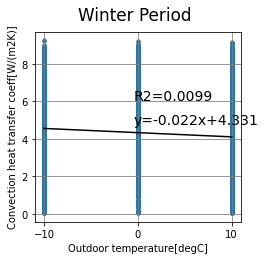

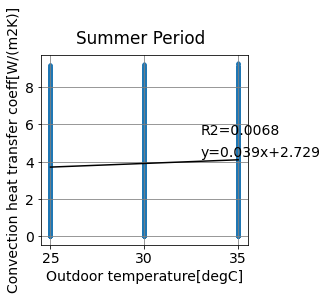

In [11]:
# 冬期条件
setPltSingle(df = df_winter,
       fig_title = "Winter Period",
       x_label = "Outdoor temperature[degC]",
       y_label = "Convection heat transfer coeff[W/(m2K)]", 
       x_data_name = "theta_e",
       y_data_name = "h_cv",
       is_fit_intercept = True
      )

# 夏期条件
setPltSingle(df = df_summer,
       fig_title = "Summer Period",
       x_label = "Outdoor temperature[degC]",
       y_label = "Convection heat transfer coeff[W/(m2K)]", 
       x_data_name = "theta_e",
       y_data_name = "h_cv",
       is_fit_intercept = True
      )

### 外気側表面に入射する日射量（j_surf）× 対流熱伝達率（h_cv）

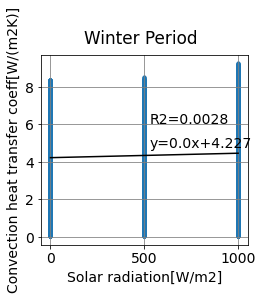

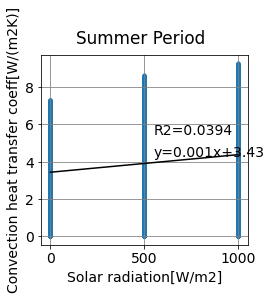

In [12]:
# 冬期条件
setPltSingle(df = df_winter,
       fig_title = "Winter Period",
       x_label = "Solar radiation[W/m2]",
       y_label = "Convection heat transfer coeff[W/(m2K)]", 
       x_data_name = "j_surf",
       y_data_name = "h_cv",
       is_fit_intercept = True
      )

# 夏期条件
setPltSingle(df = df_summer,
       fig_title = "Summer Period",
       x_label = "Solar radiation[W/m2]",
       y_label = "Convection heat transfer coeff[W/(m2K)]", 
       x_data_name = "j_surf",
       y_data_name = "h_cv",
       is_fit_intercept = True
      )

### 外気側表面日射吸収率（a_surf）× 対流熱伝達率（h_cv）

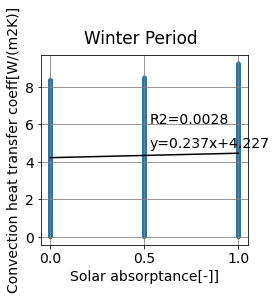

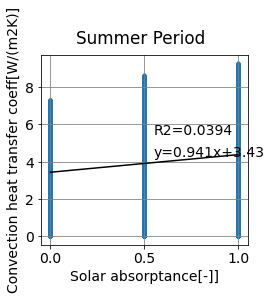

In [13]:
# 冬期条件
setPltSingle(df = df_winter,
       fig_title = "Winter Period",
       x_label = "Solar absorptance[-]]",
       y_label = "Convection heat transfer coeff[W/(m2K)]", 
       x_data_name = "a_surf",
       y_data_name = "h_cv",
       is_fit_intercept = True
      )

# 夏期条件
setPltSingle(df = df_summer,
       fig_title = "Summer Period",
       x_label = "Solar absorptance[-]]",
       y_label = "Convection heat transfer coeff[W/(m2K)]", 
       x_data_name = "a_surf",
       y_data_name = "h_cv",
       is_fit_intercept = True
      )

### 外気側部材の熱コンダクタンス（C_1）× 対流熱伝達率（h_cv）

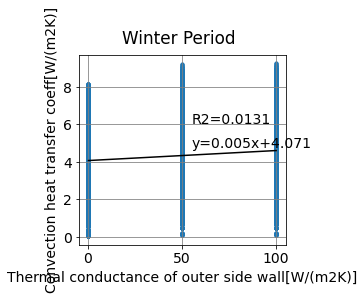

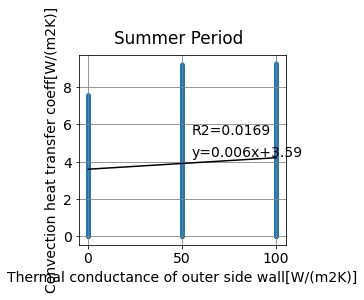

In [14]:
# 冬期条件
setPltSingle(df = df_winter,
       fig_title = "Winter Period",
       x_label = "Thermal conductance of outer side wall[W/(m2K)]",
       y_label = "Convection heat transfer coeff[W/(m2K)]", 
       x_data_name = "C_1",
       y_data_name = "h_cv",
       is_fit_intercept = True
      )

# 夏期条件
setPltSingle(df = df_summer,
       fig_title = "Summer Period",
       x_label = "Thermal conductance of outer side wall[W/(m2K)]",
       y_label = "Convection heat transfer coeff[W/(m2K)]", 
       x_data_name = "C_1",
       y_data_name = "h_cv",
       is_fit_intercept = True
      )

### 室内側部材の熱コンダクタンス（C_2）× 対流熱伝達率（h_cv）

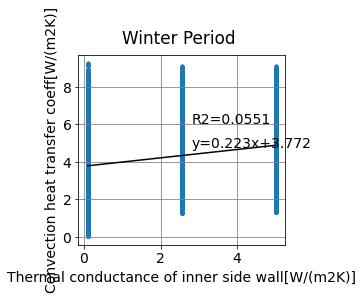

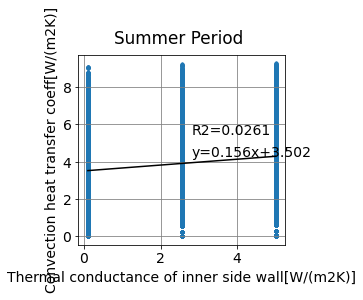

In [15]:
# 冬期条件
setPltSingle(df = df_winter,
       fig_title = "Winter Period",
       x_label = "Thermal conductance of inner side wall[W/(m2K)]",
       y_label = "Convection heat transfer coeff[W/(m2K)]", 
       x_data_name = "C_2",
       y_data_name = "h_cv",
       is_fit_intercept = True
      )

# 夏期条件
setPltSingle(df = df_summer,
       fig_title = "Summer Period",
       x_label = "Thermal conductance of inner side wall[W/(m2K)]",
       y_label = "Convection heat transfer coeff[W/(m2K)]", 
       x_data_name = "C_2",
       y_data_name = "h_cv",
       is_fit_intercept = True
      )

### 通気層の長さ（l_h）× 対流熱伝達率（h_cv）

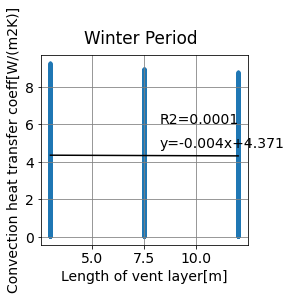

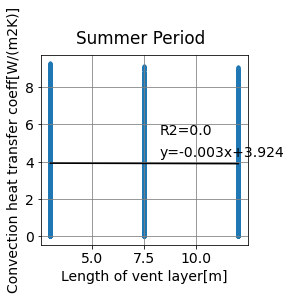

In [16]:
# 冬期条件
setPltSingle(df = df_winter,
       fig_title = "Winter Period",
       x_label = "Length of vent layer[m]",
       y_label = "Convection heat transfer coeff[W/(m2K)]", 
       x_data_name = "l_h",
       y_data_name = "h_cv",
       is_fit_intercept = True
      )

# 夏期条件
setPltSingle(df = df_summer,
       fig_title = "Summer Period",
       x_label = "Length of vent layer[m]",
       y_label = "Convection heat transfer coeff[W/(m2K)]", 
       x_data_name = "l_h",
       y_data_name = "h_cv",
       is_fit_intercept = True
      )

### 通気層の厚さ（l_d）× 対流熱伝達率（h_cv）

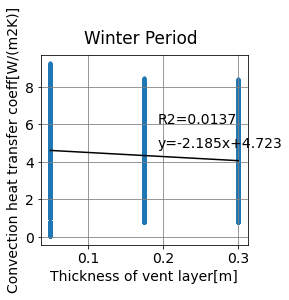

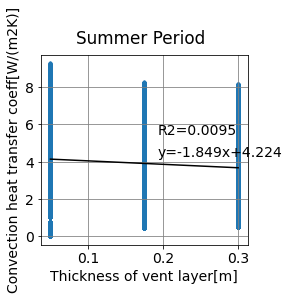

In [17]:
# 冬期条件
setPltSingle(df = df_winter,
       fig_title = "Winter Period",
       x_label = "Thickness of vent layer[m]",
       y_label = "Convection heat transfer coeff[W/(m2K)]", 
       x_data_name = "l_d",
       y_data_name = "h_cv",
       is_fit_intercept = True
      )

# 夏期条件
setPltSingle(df = df_summer,
       fig_title = "Summer Period",
       x_label = "Thickness of vent layer[m]",
       y_label = "Convection heat transfer coeff[W/(m2K)]", 
       x_data_name = "l_d",
       y_data_name = "h_cv",
       is_fit_intercept = True
      )

### 通気層の傾斜角（angle）× 対流熱伝達率（h_cv）

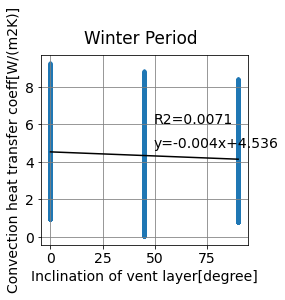

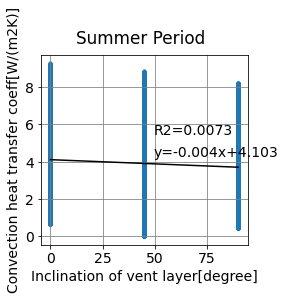

In [18]:
# 冬期条件
setPltSingle(df = df_winter,
       fig_title = "Winter Period",
       x_label = "Inclination of vent layer[degree]",
       y_label = "Convection heat transfer coeff[W/(m2K)]", 
       x_data_name = "angle",
       y_data_name = "h_cv",
       is_fit_intercept = True
      )

# 夏期条件
setPltSingle(df = df_summer,
       fig_title = "Summer Period",
       x_label = "Inclination of vent layer[degree]",
       y_label = "Convection heat transfer coeff[W/(m2K)]", 
       x_data_name = "angle",
       y_data_name = "h_cv",
       is_fit_intercept = True
      )

### 通気層の平均風速（v_a）× 対流熱伝達率（h_cv）

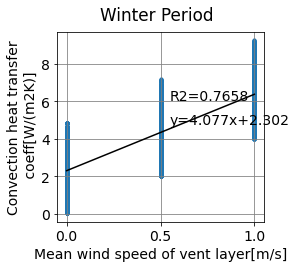

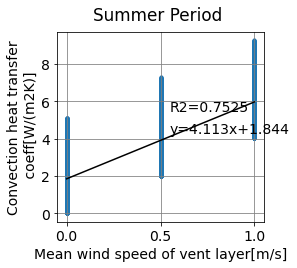

In [19]:
# 冬期条件
setPltSingle(df = df_winter,
       fig_title = "Winter Period",
       x_label = "Mean wind speed of vent layer[m/s]",
       y_label = "Convection heat transfer\n coeff[W/(m2K)]", 
       x_data_name = "v_a",
       y_data_name = "h_cv",
       is_fit_intercept = True
      )

# 夏期条件
setPltSingle(df = df_summer,
       fig_title = "Summer Period",
       x_label = "Mean wind speed of vent layer[m/s]",
       y_label = "Convection heat transfer\n coeff[W/(m2K)]", 
       x_data_name = "v_a",
       y_data_name = "h_cv",
       is_fit_intercept = True
      )

### 通気層に面する面2の放射率（emissivity_2）× 対流熱伝達率（h_cv）

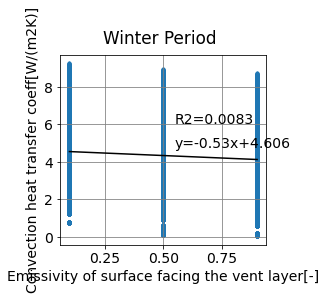

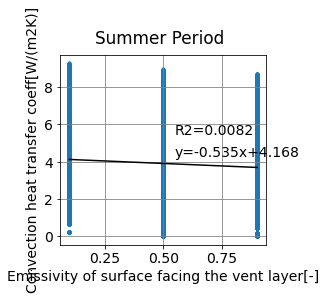

In [20]:
# 冬期条件
setPltSingle(df = df_winter,
       fig_title = "Winter Period",
       x_label = "Emissivity of surface facing the vent layer[-]",
       y_label = "Convection heat transfer coeff[W/(m2K)]", 
       x_data_name = "emissivity_2",
       y_data_name = "h_cv",
       is_fit_intercept = True
      )

# 夏期条件
setPltSingle(df = df_summer,
       fig_title = "Summer Period",
       x_label = "Emissivity of surface facing the vent layer[-]",
       y_label = "Convection heat transfer coeff[W/(m2K)]", 
       x_data_name = "emissivity_2",
       y_data_name = "h_cv",
       is_fit_intercept = True
      )

### 冬期条件、夏期条件を統合した場合の対流熱伝達率の推定式を作成する

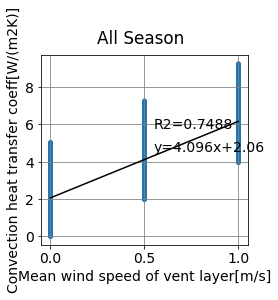

In [21]:
df_all = pd.concat([df_winter, df_summer])
setPltSingle(df = df_all,
       fig_title = "All Season",
       x_label = "Mean wind speed of vent layer[m/s]",
       y_label = "Convection heat transfer coeff[W/(m2K)]", 
       x_data_name = "v_a",
       y_data_name = "h_cv",
       is_fit_intercept = True
      )

## 対流熱伝達率の推定結果の検証
### 冬期期間の回帰式による推定結果の検証
#### 推定結果の読み込み

In [22]:
# CSVファイルを読み込む
df_winter_simple = pd.read_csv('wall_status_data_frame_h_cv_simplified_winter.csv', index_col=0)

# 冬期条件の計算結果を抽出
df_winter_simple = df_winter_simple.query("theta_e <= 10.0 & theta_r == 20.0")

# 収束しなかった場合のデータを削除する
df_winter_simple = df_winter_simple.query("is_optimize_succeed == True")

# 分析用にメッセージ列を削除
df_winter_simple = df_winter_simple.drop(["is_optimize_succeed", "optimize_message"], axis=1)

# 1つでも欠損値NaNがある行を削除する
df_winter_simple = df_winter_simple[~np.isnan(df_winter_simple).any(axis=1)]
df_winter_simple

,theta_e,theta_r,j_surf,a_surf,C_1,C_2,l_h,l_w,l_d,angle,...,h_cv,h_rv,theta_as_e,k_e,q_room_side,heat_balance_0,heat_balance_1,heat_balance_2,heat_balance_3,heat_balance_4
0,-10.0,20.0,0.0,0.0,0.5,0.1,3.0,0.05,0.05,0.0,...,2.3020,0.435052,-4.589554,0.819652,-2.347123,0.000000e+00,3.774758e-15,0.000000e+00,0.000000e+00,-2.220446e-16
1,-10.0,20.0,0.0,0.0,0.5,0.1,3.0,0.05,0.05,0.0,...,2.3020,2.078000,-4.892666,0.829756,-2.407549,0.000000e+00,3.552714e-15,0.000000e+00,2.842171e-14,-4.440892e-16
2,-10.0,20.0,0.0,0.0,0.5,0.1,3.0,0.05,0.05,0.0,...,2.3020,3.586165,-4.949289,0.831643,-2.426751,0.000000e+00,3.552714e-15,-3.552714e-15,2.842171e-14,-4.440892e-16
3,-10.0,20.0,0.0,0.0,0.5,0.1,3.0,0.05,0.05,0.0,...,4.3405,0.410913,-9.856306,0.995210,-2.892611,-2.842171e-14,1.243450e-14,0.000000e+00,0.000000e+00,-8.881784e-16
4,-10.0,20.0,0.0,0.0,0.5,0.1,3.0,0.05,0.05,0.0,...,4.3405,1.967917,-9.818938,0.993965,-2.903604,2.842171e-14,0.000000e+00,0.000000e+00,0.000000e+00,-8.881784e-16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295240,10.0,20.0,1000.0,1.0,100.0,5.0,12.0,10.00,0.30,90.0,...,4.3405,3.083654,26.320154,0.210672,14.176896,0.000000e+00,1.449507e-12,2.842171e-14,2.842171e-14,-1.776357e-15
295241,10.0,20.0,1000.0,1.0,100.0,5.0,12.0,10.00,0.30,90.0,...,4.3405,5.379391,29.614104,0.320470,23.222870,-9.094947e-13,-2.273737e-13,5.684342e-14,-5.684342e-14,0.000000e+00
295242,10.0,20.0,1000.0,1.0,100.0,5.0,12.0,10.00,0.30,90.0,...,6.3790,0.617893,15.801454,-0.139952,-9.247253,-4.547474e-13,-6.643575e-13,0.000000e+00,2.842171e-14,1.776357e-15
295243,10.0,20.0,1000.0,1.0,100.0,5.0,12.0,10.00,0.30,90.0,...,6.3790,3.001012,21.823402,0.060780,4.365123,-4.547474e-13,-4.405365e-13,5.684342e-14,-2.842171e-14,1.776357e-15


#### 対流熱伝達率の計算結果比較（ 簡易計算と詳細計算の結果を比較）

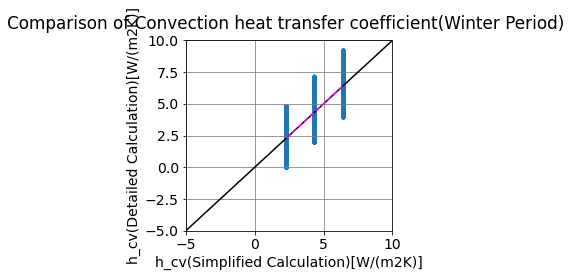

In [23]:
setPltComparison(
       fig_title = "Comparison of Convection heat transfer coefficient(Winter Period)",
       x_label = "h_cv(Simplified Calculation)[W/(m2K)]",
       y_label = "h_cv(Detailed Calculation)[W/(m2K)]", 
       x_data = df_winter_simple["h_cv"],
       y_data = df_winter["h_cv"],
       xlim_min = -5.0,
       xlim_max = 10.0,
       ylim_min = -5.0,
       ylim_max = 10.0
      )

#### 相当熱貫流率の補正係数の計算結果比較（ 簡易計算と詳細計算の結果を比較）

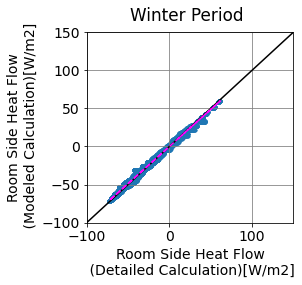

In [24]:
setPltComparison(
       #fig_title = "Comparison of Heat Flow(Winter Period)",
       #x_label = "q_room_side(Simplified Calculation)[-]",
       #y_label = "q_room_side(Detailed Calculation)[-]", 
       fig_title = "Winter Period",       
       x_label = "Room Side Heat Flow\n (Detailed Calculation)[W/m2]",
       y_label = "Room Side Heat Flow\n (Modeled Calculation)[W/m2]",
       x_data = df_winter["q_room_side"],
       y_data = df_winter_simple["q_room_side"],
       xlim_min = -100.0,
       xlim_max = 150.0,
       ylim_min = -100.0,
       ylim_max = 150.0
      )

### 夏期期間の回帰式による推定結果の検証
#### 推定結果の読み込み

In [25]:
# CSVファイルを読み込む
df_summer_simple = pd.read_csv('wall_status_data_frame_h_cv_simplified_summer.csv', index_col=0)

# 冬期条件の計算結果を抽出
df_summer_simple = df_summer_simple.query("theta_e >= 25.0 & theta_r == 27.0")

# 収束しなかった場合のデータを削除する
df_summer_simple = df_summer_simple.query("is_optimize_succeed == True")

# 分析用にメッセージ列を削除
df_summer_simple = df_summer_simple.drop(["is_optimize_succeed", "optimize_message"], axis=1)

# 1つでも欠損値NaNがある行を削除する
df_summer_simple = df_summer_simple[~np.isnan(df_summer_simple).any(axis=1)]
df_summer_simple

,theta_e,theta_r,j_surf,a_surf,C_1,C_2,l_h,l_w,l_d,angle,...,h_cv,h_rv,theta_as_e,k_e,q_room_side,heat_balance_0,heat_balance_1,heat_balance_2,heat_balance_3,heat_balance_4
413343,25.0,27.0,0.0,0.0,0.5,0.1,3.0,0.05,0.05,0.0,...,1.8440,0.596711,25.357348,0.821326,-0.156133,-1.136868e-13,-5.329071e-15,-7.105427e-15,-2.842171e-14,0.000000e+00
413344,25.0,27.0,0.0,0.0,0.5,0.1,3.0,0.05,0.05,0.0,...,1.8440,2.857358,25.336975,0.831513,-0.161086,1.136868e-13,0.000000e+00,0.000000e+00,0.000000e+00,1.776357e-15
413345,25.0,27.0,0.0,0.0,0.5,0.1,3.0,0.05,0.05,0.0,...,1.8440,4.935191,25.334888,0.832556,-0.162313,0.000000e+00,1.421085e-14,0.000000e+00,0.000000e+00,1.776357e-15
413346,25.0,27.0,0.0,0.0,0.5,0.1,3.0,0.05,0.05,0.0,...,3.9005,0.594701,25.011085,0.994457,-0.192471,1.136868e-13,2.309264e-14,4.263256e-14,2.842171e-14,0.000000e+00
413347,25.0,27.0,0.0,0.0,0.5,0.1,3.0,0.05,0.05,0.0,...,3.9005,2.848287,25.015710,0.992145,-0.193414,1.136868e-13,-1.421085e-14,2.842171e-14,-2.842171e-14,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
708583,35.0,27.0,1000.0,1.0,100.0,5.0,12.0,10.00,0.30,90.0,...,3.9005,3.814571,52.684777,0.535100,58.278129,0.000000e+00,1.904255e-12,5.684342e-14,5.684342e-14,0.000000e+00
708584,35.0,27.0,1000.0,1.0,100.0,5.0,12.0,10.00,0.30,90.0,...,3.9005,6.674766,55.724859,0.598435,70.808197,1.818989e-12,1.023182e-12,0.000000e+00,-2.842171e-14,-1.776357e-14
708585,35.0,27.0,1000.0,1.0,100.0,5.0,12.0,10.00,0.30,90.0,...,5.9570,0.764561,41.084469,0.293426,30.625996,9.094947e-13,-9.592327e-13,-5.684342e-14,0.000000e+00,7.105427e-15
708586,35.0,27.0,1000.0,1.0,100.0,5.0,12.0,10.00,0.30,90.0,...,5.9570,3.734235,48.061107,0.438773,50.835753,0.000000e+00,7.389644e-13,5.684342e-14,-5.684342e-14,1.421085e-14


#### 対流熱伝達率の計算結果比較（ 簡易計算と詳細計算の結果を比較）

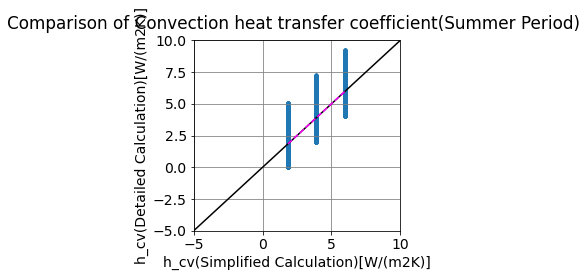

In [26]:
setPltComparison(
       fig_title = "Comparison of Convection heat transfer coefficient(Summer Period)",
       x_label = "h_cv(Simplified Calculation)[W/(m2K)]",
       y_label = "h_cv(Detailed Calculation)[W/(m2K)]", 
       x_data = df_summer_simple["h_cv"],
       y_data = df_summer["h_cv"],
       xlim_min = -5.0,
       xlim_max = 10.0,
       ylim_min = -5.0,
       ylim_max = 10.0
      )

#### 相当熱貫流率の補正係数の計算結果比較（ 簡易計算と詳細計算の結果を比較）

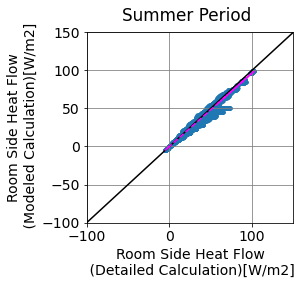

In [27]:
setPltComparison(
       #fig_title = "Comparison of Heat Flow(Summer Period)",
       #x_label = "q_room_side(Simplified Calculation)[-]",
       #y_label = "q_room_side(Detailed Calculation)[-]", 
       fig_title = "Summer Period",
       x_label = "Room Side Heat Flow\n (Detailed Calculation)[W/m2]",
       y_label = "Room Side Heat Flow\n (Modeled Calculation)[W/m2]",
       x_data = df_summer["q_room_side"],
       y_data = df_summer_simple["q_room_side"],
       xlim_min = -100.0,
       xlim_max = 150.0,
       ylim_min = -100.0,
       ylim_max = 150.0
      )

### 通年の回帰式による推定結果の検証
#### 推定結果の読み込み

In [28]:
# CSVファイルを読み込む
df_all_simple = pd.read_csv('wall_status_data_frame_h_cv_simplified_all_season.csv', index_col=0)

# 冬期条件、夏期条件の計算結果を抽出
df_all_simple = pd.concat([df_all_simple.query("theta_e <= 10.0 & theta_r == 20.0"), df_all_simple.query("theta_e >= 25.0 & theta_r == 27.0")])

# 収束しなかった場合のデータを削除する
df_all_simple = df_all_simple.query("is_optimize_succeed == True")

# 分析用にメッセージ列を削除
df_all_simple = df_all_simple.drop(["is_optimize_succeed", "optimize_message"], axis=1)

# 1つでも欠損値NaNがある行を削除する
df_all_simple = df_all_simple[~np.isnan(df_all_simple).any(axis=1)]
df_all_simple

,theta_e,theta_r,j_surf,a_surf,C_1,C_2,l_h,l_w,l_d,angle,...,h_cv,h_rv,theta_as_e,k_e,q_room_side,heat_balance_0,heat_balance_1,heat_balance_2,heat_balance_3,heat_balance_4
0,-10.0,20.0,0.0,0.0,0.5,0.1,3.0,0.05,0.05,0.0,...,2.060,0.435238,-4.572714,0.819090,-2.337615,-5.684342e-14,3.330669e-15,0.000000e+00,2.842171e-14,0.000000e+00
1,-10.0,20.0,0.0,0.0,0.5,0.1,3.0,0.05,0.05,0.0,...,2.060,2.078218,-4.900733,0.830024,-2.405226,0.000000e+00,-8.881784e-15,7.105427e-15,2.842171e-14,0.000000e+00
2,-10.0,20.0,0.0,0.0,0.5,0.1,3.0,0.05,0.05,0.0,...,2.060,3.586340,-4.955787,0.831860,-2.425667,0.000000e+00,0.000000e+00,7.105427e-15,-2.842171e-14,0.000000e+00
3,-10.0,20.0,0.0,0.0,0.5,0.1,3.0,0.05,0.05,0.0,...,4.108,0.410991,-9.856825,0.995227,-2.889631,0.000000e+00,-7.105427e-15,0.000000e+00,-2.842171e-14,1.776357e-15
4,-10.0,20.0,0.0,0.0,0.5,0.1,3.0,0.05,0.05,0.0,...,4.108,1.968275,-9.814716,0.993824,-2.901482,0.000000e+00,7.105427e-15,-7.105427e-15,0.000000e+00,-8.881784e-16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
708583,35.0,27.0,1000.0,1.0,100.0,5.0,12.0,10.00,0.30,90.0,...,4.108,3.809592,52.341814,0.527954,57.935782,-9.094947e-13,-1.136868e-12,5.684342e-14,0.000000e+00,-1.065814e-14
708584,35.0,27.0,1000.0,1.0,100.0,5.0,12.0,10.00,0.30,90.0,...,4.108,6.664155,55.375549,0.591157,70.246411,0.000000e+00,-1.705303e-13,0.000000e+00,0.000000e+00,7.105427e-15
708585,35.0,27.0,1000.0,1.0,100.0,5.0,12.0,10.00,0.30,90.0,...,6.156,0.764104,41.037012,0.292438,30.808758,0.000000e+00,2.309264e-13,5.684342e-14,-2.842171e-14,-7.105427e-15
708586,35.0,27.0,1000.0,1.0,100.0,5.0,12.0,10.00,0.30,90.0,...,6.156,3.729997,47.843631,0.434242,50.558905,-9.094947e-13,8.242296e-13,1.136868e-13,0.000000e+00,-7.105427e-15


#### 対流熱伝達率の計算結果比較（ 簡易計算と詳細計算の結果を比較）

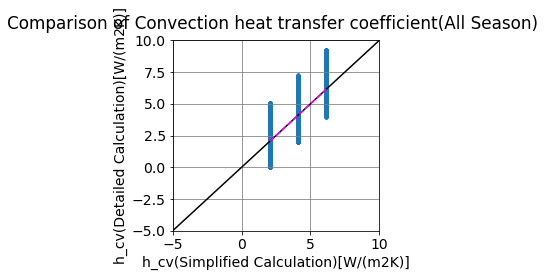

In [29]:
setPltComparison(
       fig_title = "Comparison of Convection heat transfer coefficient(All Season)",
       x_label = "h_cv(Simplified Calculation)[W/(m2K)]",
       y_label = "h_cv(Detailed Calculation)[W/(m2K)]", 
       x_data = df_all_simple["h_cv"],
       y_data = df_all["h_cv"],
       xlim_min = -5.0,
       xlim_max = 10.0,
       ylim_min = -5.0,
       ylim_max = 10.0
      )

#### 相当熱貫流率の補正係数の計算結果比較（ 簡易計算と詳細計算の結果を比較）

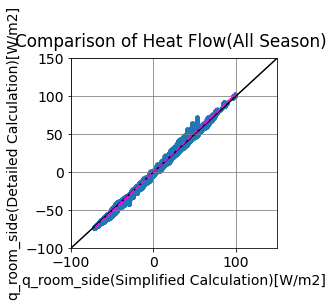

In [30]:
setPltComparison(
       fig_title = "Comparison of Heat Flow(All Season)",
       x_label = "q_room_side(Simplified Calculation)[W/m2]",
       y_label = "q_room_side(Detailed Calculation)[W/m2]", 
       x_data = df_all_simple["q_room_side"],
       y_data = df_all["q_room_side"],
       xlim_min = -100.0,
       xlim_max = 150.0,
       ylim_min = -100.0,
       ylim_max = 150.0
      )